# Exploring Tweets data for monitoring Disaster using the exploratory data analysis (EDA) notebook

#### Introduction

This notebook is the first step in the DS4A Team 155 Project: Exploratory Data Analysis.
Social Networks have become a crucial communication channel in emergencies since users may report concerning situations in real-time. As a result, more agencies (i.e. disaster relief organizations and news agencies) are interested in monitoring Social Networks such as Twitter. However, tweets from people may or may not be actually realted to disasters. Therefore, machine learning models which predict real-time publication about emergencies and disasters are required.
From a set of different tweets, this project aims to predict which Tweets are about real disasters and which ones are not.


##### The proposed EDA approach to analysis the twitter messages is divided as follows: 
- Import the libraries
- Input Data
- Basic Informations
- Clean the data
- Feature Engineering
- Analizing Data
- Process Data
- Summary


### Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import string
import plotly
import re

from nltk.stem import PorterStemmer 
from pylab import rcParams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from collections import defaultdict
from nltk.util import ngrams
# Importing the required parameter for plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oscar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oscar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

### Input Data

The data for this project includes 10876 tweets, divided into two different datasets: a train dataset (7613 tweets) and a test dataset (3263 tweets)
The datasets have the following columns:


The train dataset has the following columns:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this feature denotes whether a tweet is about a real disaster (1) or not (0)


#### Train dataset

In [3]:
locations = pd.read_csv('Data/worldcities.csv')
locations = locations[["city", "country",'iso3']].astype(str)
locations['city']=locations['city'].str.lower()
locations['country']=locations['country'].str.lower()
locations


city      country iso3
0            tokyo        japan  JPN
1          jakarta    indonesia  IDN
2            delhi        india  IND
3           manila  philippines  PHL
4        são paulo       brazil  BRA
...            ...          ...  ...
42900       tukchi       russia  RUS
42901        numto       russia  RUS
42902         nord    greenland  GRL
42903  timmiarmiut    greenland  GRL
42904      nordvik       russia  RUS

[42905 rows x 3 columns]

In [4]:
df = pd.read_csv('Data/train.csv', dtype={'id': int, 'keyword': object, 'location': object, 'text': object, 'target': int})
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

#### Test dataset

The test dataset is the verification values ​​of the prediction model on disasters and does not have the target column in order to validate if the result of the model on the analyzed text is correct (validation of the tweet)

In [5]:
df_test = pd.read_csv('Data/test.csv', dtype={'id': int, 'keyword': object, 'location': object, 'text': object})
df_test.head(5)

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

### Basic Informations

 In this case we use the info() function to print a concise summary of a DataFrame.This method prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage. For our case, we have 7613 rows and 5 columns. Location is the column with the most null values, followed by the Keywords column. Also, we can see that we have two data types: int32 and object.


In [6]:
df.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int32 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int32 
dtypes: int32(2), object(3)
memory usage: 238.0+ KB


The describe() method returns a description of the data in the df. If the df contains numerical data, the description contains: count, mean, std, min, percentiles (25%,50%,75%) and max columns. 

In [7]:
df.describe( )

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

In our DataFrame, we can find two numerical columns: id & target. For this case, we have complete information for the 7613 tweets (non null values). The mean of the target column is 0.42966, which means that most of the tweets do not correspond to a disaster (0: not disaster, 1: disaster), we can verify this information in the value counts function of the target column, that show us that we have 4342 with “0” target and 3271 with “1” target.

In [8]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

With the function “df.isnull().sum()” we are adding the number of null values ​​that we have in each column. As we mentioned before, the column with the most null values is location with 2533 null values, followed by the Keyword column with 61 null values.


In [9]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

##### Observations

- There is a total of 7613 entries (train)
- There are numerous blanks in the dataset that need to be replaced with NA


### Clean Data

In the clean data part will be analyzed the characteristics of the information provided. This analysis is done based on the form of the data (uppercase, lowercase, etc.), the missing data, wrongly formatted data (for example, that in the text character cell it has a numeric data, they have special characters or links), the length of the tweet and how many words they have.


#### Removing rows, which own non-numerical values in the target column

In this part, we have a dataset that was classified by natural disaster based on a text provided by a tweet. To avoid having data that was not classified in the train part, we remove the data that has no classification with the .notnull() function.



In [10]:
df[pd.to_numeric(df['target'], errors='coerce').notnull()]

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

In the target column, a value other than 1 and 0 may have been entered during the classification stage. In this step, the dataset is filtered only by the values ​​that have a 1 and a 0 in the target.

#### Removing rows, which have not 1 and 0 values in target column


In the target column, a value other than 1 and 0 may have been entered during the classification stage. In this step, the dataset is filtered only by the values ​​that have a 1 and a 0 in the target. This step is done focused on the model of not having data that does not have a classification.



In [11]:
def is_valid_number(x):
    if x == 1 or x == 0:
        return True
    else:
        return True
df[df['target'].apply(lambda x: is_valid_number(x))]

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

#### Removing punctuations and numbers

In this part we will focus on the text column. Within this column, there is the tweet and it is sought to eliminate the punctuation marks and numbers, which add length to the text but do not add value to the message.


In [12]:
df['text_clean'] = df['text'].str.replace('[^\w\s]', '', regex=True).str.replace('\d+', '', regex=True)
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  
0       1  Our Deeds are the Reason of this earthquake Ma...  
1       1              Forest fire near La Ronge Sask Canada  
2       1  All residents asked to shelter in place are be...  
3       1   people receive wildfires evacuation orders in...  
4       1  Just got sent this photo from Ruby Alaska as s...

#### Removing uppercase

The characters have variations of uppercase and lowercase, but represent the same word. To avoid this situation, in this part of the code for the entire text column we convert the entire text string to lowercase using the "lower" function


In [13]:
df['text_clean']=df['text_clean'].apply(lambda x: x.lower())
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  
0       1  our deeds are the reason of this earthquake ma...  
1       1              forest fire near la ronge sask canada  
2       1  all residents asked to shelter in place are be...  
3       1   people receive wildfires evacuation orders in...  
4       1  just got sent this photo from ruby alaska as s...

#### Removing hyperlink

In this part we will focus on the text column. Within this column, there is the tweet and it is sought to eliminate hiperlink, which add length to the text but does not add value to the message. We use the regex library  and replace all the possible hyperlink 



In [14]:
df['text_clean']=df['text_clean'].apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x))
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  
0       1  our deeds are the reason of this earthquake ma...  
1       1              forest fire near la ronge sask canada  
2       1  all residents asked to shelter in place are be...  
3       1   people receive wildfires evacuation orders in...  
4       1  just got sent this photo from ruby alaska as s...

#### Removing square brackets

In this part we will focus on the text column. Within this column, there is the tweet and it is sought to eliminate the brackets, which add length to the text but does not add value to the message. We use the regex library  and replace all the possible hyperlink 


In [15]:
df['text_clean']=df['text_clean'].apply(lambda x:re.sub('\[.*?\]', '', x))
df['text_clean']=df['text_clean'].apply(lambda x:re.sub('<.*?>+', '', x))
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  
0       1  our deeds are the reason of this earthquake ma...  
1       1              forest fire near la ronge sask canada  
2       1  all residents asked to shelter in place are be...  
3       1   people receive wildfires evacuation orders in...  
4       1  just got sent this photo from ruby alaska as s...

### Feature Engineering

#### Counting the number of words

Using a lambda function, we split the text in the “text clean” column and count how many words there are in each tweet. For example, the tweet with id=1 has 13 words.


In [16]:
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  word_count  
0       1  our deeds are the reason of this earthquake ma...          13  
1       1              forest fire near la ronge sask canada           7  
2       1  all residents asked to shelter in place are be...          22  
3       1   people receive wildfires evacuation orders in...           7  
4       1  just got sent this photo from ruby alaska as s...          16

#### Adding the text length 

Similarly, we can calculate how many characters there are in each tweet, applying just the len(x) function. The tweet with id=1 has 68 characters:


In [17]:
df['size'] = df['text_clean'].apply(lambda x: len(x))
df.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  word_count  size  
0       1  our deeds are the reason of this earthquake ma...          13    68  
1       1              forest fire near la ronge sask canada           7    37  
2       1  all residents asked to shelter in place are be...          22   130  
3       1   people receive wildfires evacuation orders in...           7    58  
4       1  just got sent this photo from ruby alaska as s...          16    86

### Analizing Data

#### Number of Tweets with disasters (1) and non-disasters (0)

We can plot a bar graph to check how many tweets are disasters and how many are not. We take the target column to a new dataframe and plot the graph using seaborn:


<AxesSubplot:ylabel='target'>

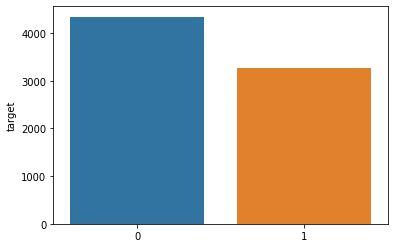

In [18]:
df_target = df['target'].value_counts().to_frame()

## seaborn barplot to display barchart
rcParams['figure.figsize'] = 5, 4
sns.barplot(data=df_target, x=df_target.index, y="target")

We can see that there are more non-disaster tweets (0).

#### Top twenty locations 

Although not every tweet has location information, we can investigate which cities or countries are more represented in the dataset. We calculate the value counts for the column “location” and plot the top 20 results in a bar graph.


<AxesSubplot:>

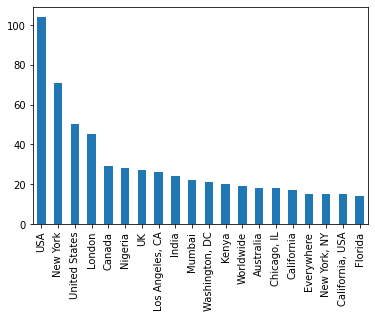

In [19]:
top_location = df["location"].value_counts().head(20)
top_location.plot(kind='bar')

The top locations are “USA”, “New York”, “United States” and “London”. Clearly, USA and United States refer to the same country, and New York is a city in that country. Therefore, it is a good idea to standardize the locations, specially the ones that refer to the same country (USA = United States). However, we will probably leave both cities and countries in our location column, as it is good to have location up to a city scale, even though some of the tweets have only the country and there is no way to find from which city they were written.

#### Histogram of the text size 

In the following histogram, we can see the distribution of the length (characters) of the tweets, which is left-skewed. As expected, there are very few short tweets, and most of them have approximately 120 characters. The maximum number of characters is 140, and therefore we can deduce that this dataset has tweets that were sent before november 2017, when twitter decided to double the character limit from 140 to 280 characters.  

<AxesSubplot:>

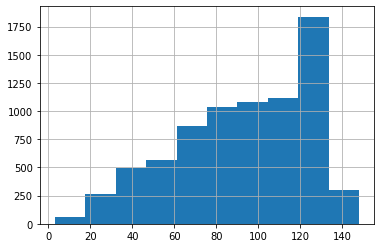

In [20]:
df['size'].hist()

#### Histogram of the number words

Conversely, the following histogram of the amount of words in the tweets is relatively symmetric, although it has a bit of a longer right tail. We can see that most tweets have between 10 and 18 words.

<AxesSubplot:>

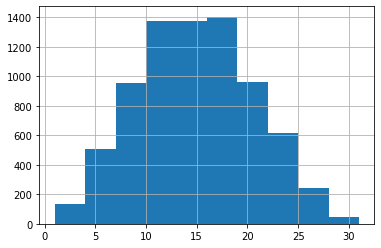

In [21]:
df['word_count'].hist()

#### Histogram of the average word length

Finally, we plot a histogram of the average word length in each tweet. We can see that it is a right-skewed distribution and that the average word length in most tweets is 5 to 6 characters. 


<AxesSubplot:>

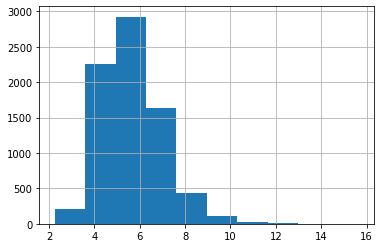

In [22]:
df['text_clean'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Process data

#### Word tokenization

In [23]:
AllReviews = df['text_clean']
AllReviews.head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text_clean, dtype: object

In [24]:
review_words_lengths = AllReviews.apply(lambda x: len(nltk.word_tokenize(x)))

#### Sentences with two words

In [25]:
AllReviews[review_words_lengths[review_words_lengths == 2].index].head(5)

22                       love skiing
30                           the end
113    aftershock httpstcoxmwodfmtui
131      aftershock httpstcojvppkhjy
276                apocalypse please
Name: text_clean, dtype: object

#### Max and min values in the number of words

In [26]:
print("Minimun number of words", min(review_words_lengths))
print("Maximum number of words", max(review_words_lengths))

Minimun number of words 1
Maximum number of words 31


#### Histogram of the tokenization words

<AxesSubplot:>

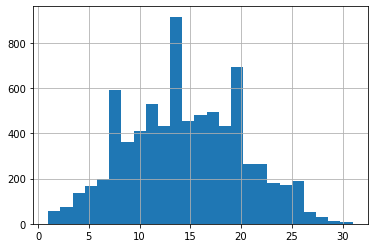

In [27]:
## Setting the resolution for better clarity 
review_words_lengths.hist(bins = 25)

The results of the tokenization process show that there is a significant concentration in the groups of tweets that have a number of words between 10 and 20 words. Being the lengths of 13 and 14 where the majority of the tweets are found, with more than 1000 records only in those two lengths. In general terms, it could be said that most of the tweets don’t really correspond to natural disasters, because in the middle of an emergency there is not enough time to write a very long tweet.

#### Histogram of the tokenization words for disaster

<AxesSubplot:>

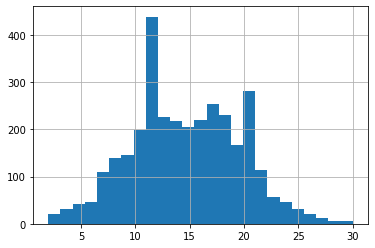

In [28]:
disaster = df[df.target == 1] 
Reviews_disaster = disaster['text_clean'] 
review_words_lengths_disaster = Reviews_disaster.apply(lambda x: len(nltk.word_tokenize(x)))
review_words_lengths_disaster.hist(bins = 25)

This histogram shows what was intuited in the analysis of the previous histogram. Analyzing only the tokenization of tweets that actually correspond to disasters, the distribution of most tweets leans towards shorter lengths than those shown in the histogram without the filtered data.

In conclusion, the precaution that must be taken when training the model must be taken into account, due to the little information that a tweet that corresponds to disaster can contain (remember that the stop words are generating noise when generating the histogram).
In the word cloud diagram that corresponds to positive tweets for disaster, it can be seen that there are keywords that indicate what may be the most recurrent disasters or events in the dataset, such as fires, landslides, terrorist attacks and accidents. Noise can also be evidenced in the data generated by the stop words.


#### Text visualization with word clouds

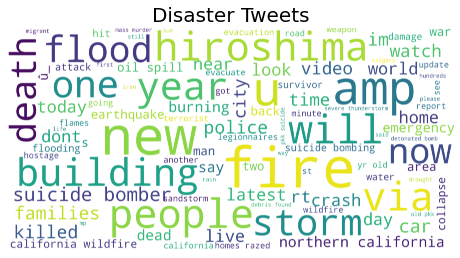

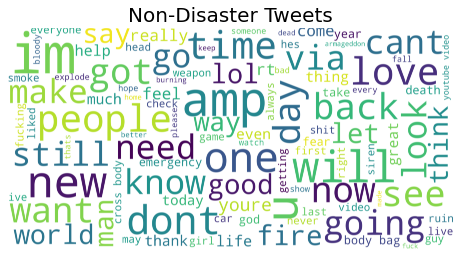

In [29]:
def word_cloud_rating(data, target_value, title, columna):
    
    data_filtered = data[data.target == target_value] #filtering according to the star value
    Reviews = data_filtered[columna]

    Reviews_text = ' '.join(Reviews.values) #joining all the words together

    # Creating a word cloud object
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",scale = 10,width=800, height=400).generate(Reviews_text)

    # Plotting the generated word cloud

    plt.figure(figsize=(8, 19))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title,fontsize=20);
    plt.axis("off")
    plt.show()
    
##### Filtering by target equal 1    
word_cloud_rating(df, 1, 'Disaster Tweets', "text_clean")

##### Filtering by target equal 0    
word_cloud_rating(df, 0, 'Non-Disaster Tweets', "text_clean")

 In the word cloud diagram that corresponds to positive tweets for disaster, it can be seen that there are keywords that indicate what may be the most recurrent disasters or events in the dataset, such as fires, landslides, terrorist attacks and accidents. Noise can also be evidenced in the data generated by the stop words.
As expected, in the tweets that are not related to disasters, there are no words that have a critical meaning or a disaster relationship, for instance, words like people, love, world and time are the most relevant.


#### Most common keywords

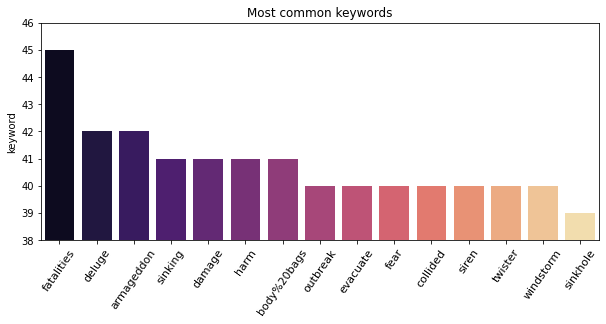

In [30]:
common_keywords = df["keyword"].value_counts().to_frame().head(15)
fig = plt.figure(figsize=(10,4))
sns.barplot(data=common_keywords, x=common_keywords.index, y="keyword",palette="magma")
plt.ylim(38, 46)
plt.title("Most common keywords")
plt.xticks(rotation=55, size=11);

 In the analysis of the distribution of the data in terms of keywords, there is a main word that is transversal to any catastrophic event and that is "fatalities". Then, there are the words related to events that have the component of rain. There are some words that have an important role and that are related to the impact generated by disasters, words like fear, damage, injuries, etc.

#### Most commun words in the tweets

In [31]:
counter = Counter()
for text in df['text'].values:
    for word in text.split():
        counter[word] += 1
counter.most_common(20)

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('I', 1197),
 ('for', 820),
 ('is', 814),
 ('on', 773),
 ('-', 763),
 ('you', 632),
 ('The', 552),
 ('my', 549),
 ('with', 508),
 ('that', 492),
 ('at', 485),
 ('by', 469),
 ('it', 433),
 ('from', 372)]

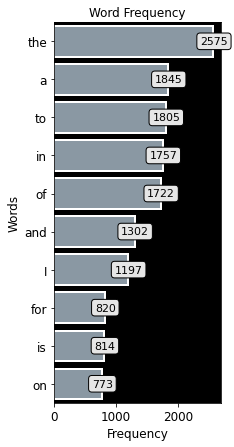

In [32]:
data = dict(sorted(counter.items(), key = lambda x: x[1] ,reverse = True)[:10])
words = list(data.keys())
frequency = list(data.values())
frequency

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 7))
ax.set_facecolor('black')
ax = sns.barplot(x = frequency, y = words, color = '#8699A7', edgecolor = 'white', linewidth = 2)
plt.title('Word Frequency', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
    width = p.get_width()
    plt.text(9.5 + p.get_width(), p.get_y() + 0.5 * p.get_height(), '{:1.0f}'.format(width), 
             ha = 'center', 
             va = 'center', 
             color = 'black', 
             bbox = bbox_args, 
             fontsize = 11)
plt.show()

Finally, in the analysis of the frequency of each word, it is evident that the largest amounts are found in the stop words. This confirms what was previously mentioned, when it was said that when these types of words are not removed, noise is created in the data that biases any analysis that one wants to carry out on the composition of the words.

In [33]:
 #   __  __    ___     ____   _  __  _   _   ____  
 #  |  \/  |  / _ \   / ___| | |/ / | | | | |  _ \ 
 #  | |\/| | | | | | | |     | ' /  | | | | | |_) |
 #  | |  | | | |_| | | |___  | . \  | |_| | |  __/ 
 #  |_|  |_|  \___/   \____| |_|\_\  \___/  |_|    
                                                

<img src="mockup.png"> 

In [34]:
 #  ___                   ____                   _     _         _____   ____       _    
 # |_ _|  _ __           |  _ \    ___   _ __   | |_  | |__     | ____| |  _ \     / \   
 #  | |  | '_ \   _____  | | | |  / _ \ | '_ \  | __| | '_ \    |  _|   | | | |   / _ \  
 #  | |  | | | | |_____| | |_| | |  __/ | |_) | | |_  | | | |   | |___  | |_| |  / ___ \ 
 # |___| |_| |_|         |____/   \___| | .__/   \__| |_| |_|   |_____| |____/  /_/   \_\
 #                                      |_|                                              

#  Removing stop words in the tweets

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
df['tokenizado'] = df['text_clean'].apply(lambda x: word_tokenize(x))
df.head(3)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target                                         text_clean  word_count  \
0       1  our deeds are the reason of this earthquake ma...          13   
1       1              forest fire near la ronge sask canada           7   
2       1  all residents asked to shelter in place are be...          22   

   size                                         tokenizado  
0    68  [our, deeds, are, the, reason, of, this, earth...  
1    37      [forest, fire, near, la, ronge, sask, canada]  
2   130  [all, residents, asked, to, shelter, in, place...

In [37]:
df['text_clean_non_stopwords'] = df['tokenizado'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))
df.head(3)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target                                         text_clean  word_count  \
0       1  our deeds are the reason of this earthquake ma...          13   
1       1              forest fire near la ronge sask canada           7   
2       1  all residents asked to shelter in place are be...          22   

   size                                         tokenizado  \
0    68  [our, deeds, are, the, reason, of, this, earth...   
1    37      [forest, fire, near, la, ronge, sask, canada]   
2   130  [all, residents, asked, to, shelter, in, place...   

                            text_clean_non_stopwords  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...

###  Comparing disaster vs non-disaster without stop words


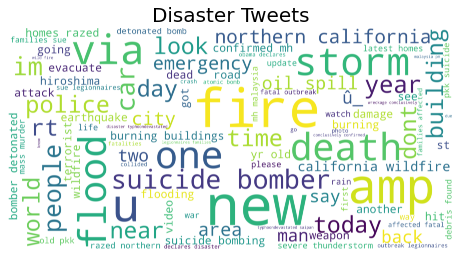

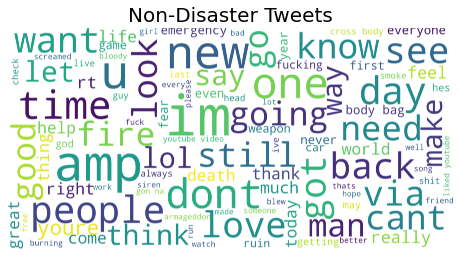

In [38]:
##### Filtering by target equal 1    
word_cloud_rating(df, 1, 'Disaster Tweets', "text_clean_non_stopwords")

##### Filtering by target equal 0    
word_cloud_rating(df, 0, 'Non-Disaster Tweets', "text_clean_non_stopwords")

### Most commun word without stop words

In [39]:
def palabras_principales(numero_palabras, df, columna, target_value):
    counter = Counter()
    for text in  df[df.target == target_value]["text_clean_non_stopwords"].values:
        for word in text.split():
            counter[word] += 1
    data = dict(sorted(counter.items(), key = lambda x: x[1] ,reverse = True)[:numero_palabras])
    words = list(data.keys())
    frequency = list(data.values())
    return frequency, words

In [40]:
frequency_dis, words_dis = palabras_principales(20, df, "text_clean_non_stopwords", 1)
frequency_non, words_non = palabras_principales(20, df, "text_clean_non_stopwords", 0)

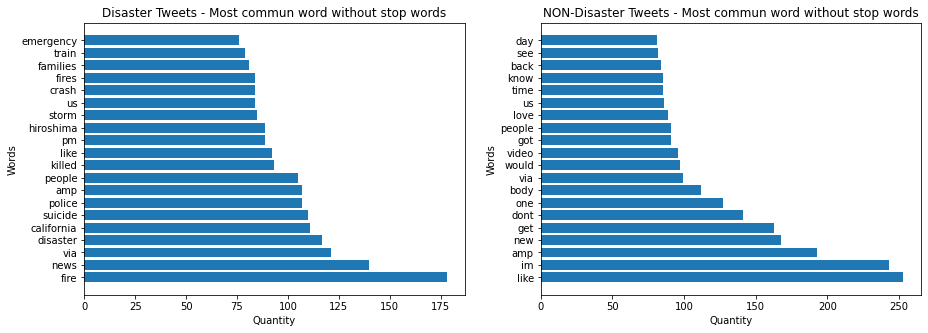

In [41]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.barh(words_dis, frequency_dis)
plt.title('Disaster Tweets - Most commun word without stop words')
plt.ylabel('Words')
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
plt.barh(words_non, frequency_non)
plt.title('NON-Disaster Tweets - Most commun word without stop words')
plt.ylabel('Words')
plt.xlabel('Quantity')
plt.show()

## Feature Engineering for text with non-stopwords

In [42]:
df['word_count_non_stopwords'] = df['text_clean_non_stopwords'].apply(lambda x: len(x.split()))
df['size_non_stopwords'] = df['text_clean_non_stopwords'].apply(lambda x: len(x))
df.head(3)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target                                         text_clean  word_count  \
0       1  our deeds are the reason of this earthquake ma...          13   
1       1              forest fire near la ronge sask canada           7   
2       1  all residents asked to shelter in place are be...          22   

   size                                         tokenizado  \
0    68  [our, deeds, are, the, reason, of, this, earth...   
1    37      [forest, fire, near, la, ronge, sask, canada]   
2   130  [all, residents, asked, to, shelter, in, place...   

                            text_clean_non_stopwords  \
0       deeds reason earthquake may allah forgive us   
1              forest fire near la ronge sask canada   
2  residents asked shelter place notified officer...   

   word_count_non_stopwords  size_non_stopwords  
0                         7                  44  
1                         7                  37  
2                        11                  88

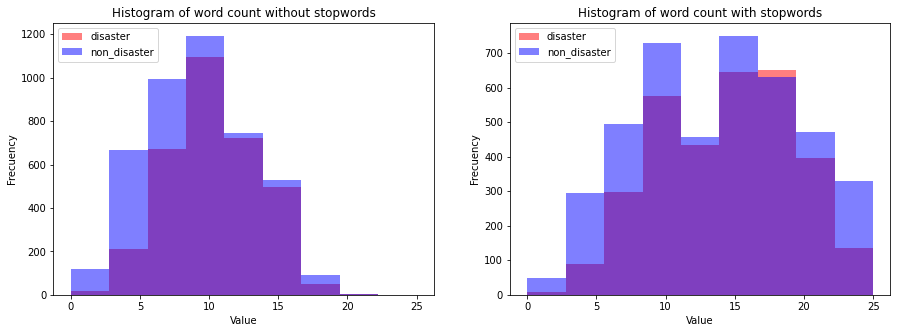

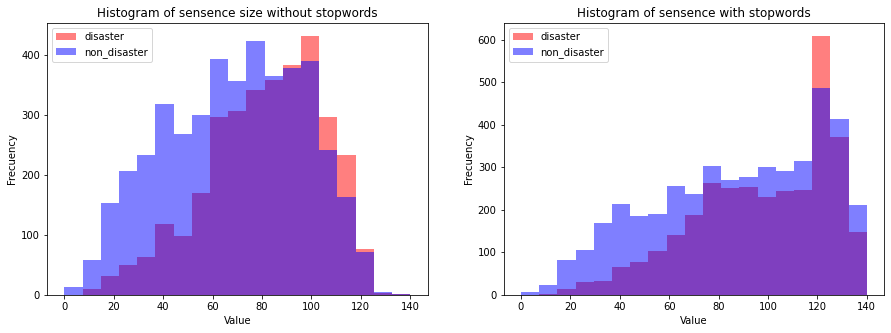

In [43]:
def plot_size(columna1, columna2, title1,title2, maximo, bins_size):
    bins = np.linspace(0, maximo, bins_size)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.hist(df[df.target == 1][columna1], bins, alpha=0.5, label='disaster', color ='red')
    plt.hist(df[df.target == 0][columna1], bins, alpha=0.5, label='non_disaster', color ='blue')
    plt.xlabel('Value')
    plt.ylabel('Frecuency')
    plt.legend(loc='upper left')
    plt.title('Histogram of '+title1 )
      
    plt.subplot(1, 2, 2)
    
    plt.hist(df[df.target == 1][columna2], bins, alpha=0.5, label='disaster', color ='red')
    plt.hist(df[df.target == 0][columna2], bins, alpha=0.5, label='non_disaster', color ='blue')
    plt.xlabel('Value')
    plt.ylabel('Frecuency')
    plt.legend(loc='upper left')
    plt.title('Histogram of '+title2 )
    plt.show()

plot_size('word_count_non_stopwords','word_count', 'word count without stopwords','word count with stopwords',25,10)
plot_size('size_non_stopwords','size', 'sensence size without stopwords','sensence with stopwords',140,20)

### BIGRAMS FOR TWEETS (WITH NON STOPWORDS)

In [44]:
word_tokens = nltk.word_tokenize(''.join(df['text_clean_non_stopwords']))

### Bigram

In [45]:
bigrams_series = (pd.Series(nltk.ngrams(word_tokens, 2)).value_counts())[:10]
bigrams_series

(burning, buildings)      50
(youtube, video)          43
(suicide, bomber)         41
(northern, california)    41
(gon, na)                 40
(cross, body)             39
(oil, spill)              37
(california, wildfire)    32
(bomber, detonated)       30
(suicide, bombing)        29
dtype: int64

### Trigram

In [46]:
trigrams_series = (pd.Series(nltk.ngrams(word_tokens, 3)).value_counts())[:10]
trigrams_series

(suicide, bomber, detonated)               30
(northern, california, wildfire)           29
(bomber, detonated, bomb)                  28
(pkk, suicide, bomber)                     28
(homes, razed, northern)                   27
(razed, northern, california)              27
(old, pkk, suicide)                        27
(affected, fatal, outbreak)                26
(declares, disaster, typhoondevastated)    25
(families, affected, fatal)                25
dtype: int64

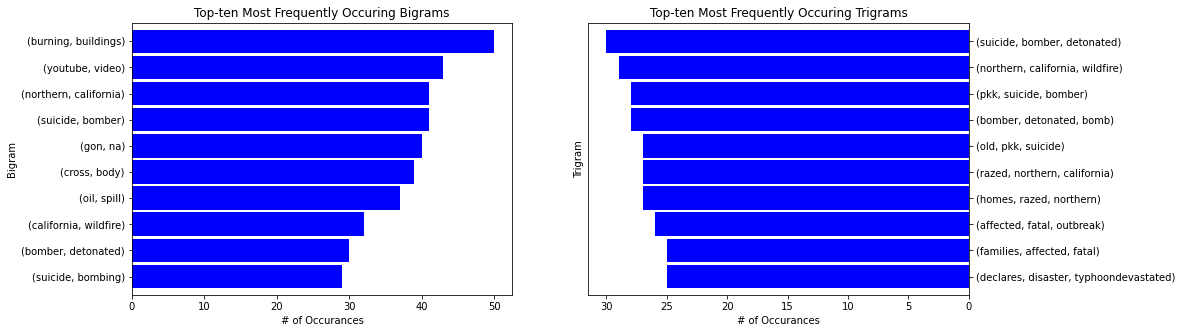

In [47]:
f = plt.figure(figsize=(15, 5))
ax1 =  f.add_subplot(121)
bigrams_series.sort_values().plot.barh(color='blue', width=.9)
plt.title('Top-ten Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

ax2 = f.add_subplot(122)
trigrams_series.sort_values().plot.barh(color='blue', width=.9)
plt.gca().invert_xaxis()
ax2.yaxis.tick_right()
plt.title('Top-ten Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')
plt.show()

## Cleaning the country names

### Plot for check the missing values of location's column

<AxesSubplot:>

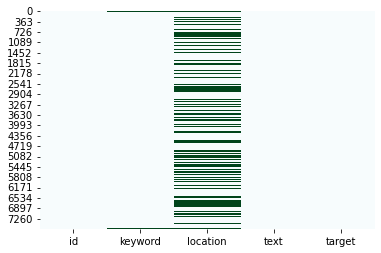

In [48]:
#this plot the color color green represent the missing values all the plot must be have white color. its the reason for try
#extract the location of the text of the tweet.
dfx = pd.read_csv('Data/train.csv', dtype={'id': int, 'keyword': object, 'location': object, 'text': object, 'target': int})
sns.heatmap(dfx.isnull(), cbar=False,cmap="BuGn")

### Special Values

THERE ARE 2 PROBLEMS IN THIS COLUMN (MISSING VALUES AND THE SPACIAL VALUES)

In [49]:
df['location']=df['location'].copy().astype(str)
print( " "+ str(int(df[df['location']!='nan']['location'].count())) + ' valores diferentes de nan con caracteres especiales')
df[df['location']!='nan']['location'].sort_values(ascending=True)


 5080 valores diferentes de nan con caracteres especiales


6771                          
7571                  Glasgow 
1797      Melbourne, Australia
2752                      News
3757                       å_ 
                 ...          
4165           å_: ?? ÌÑ ? : ?
6834      å_å_Los Mina Cityã¢
6989        å¡å¡Midwest Û¢Û¢
7183         åÊ(?Û¢`?Û¢å«)??
2419               åø\_(?)_/åø
Name: location, Length: 5080, dtype: object

### Dictonary location and extract the country

In [50]:
dict_locations = locations.set_index('city').to_dict()['country']
dict_isos=locations.set_index('country').to_dict()['iso3']


### Unique Country

In [51]:
paisesUnicos = list(np.unique(np.array(list(dict_locations.values()))))

### Extract the country and put the iso (key name)

In [52]:
#sacar los nombres de una columna y compararlos con la lista de paises.
def devolverPais(frase,textclean):
    valor = None
    
    if 'uk' in frase or 'uk' in textclean :
        valor= 'GBR'
    elif 'usa' in frase or 'usa' in textclean:
        valor= 'USA'
    elif 'us' in frase or 'us' in textclean:
        valor='USA'    
    else:
        for llave in paisesUnicos:
            if str(llave) in str(frase):
                valor = dict_isos[str(llave)] 
                break
   
        if (valor is None):
    
            for llave in dict_locations.keys():
                if str(llave) in str(frase):
                    valor = dict_isos[str(dict_locations[llave])]
                    break
    
    
        if (valor is None):
            for pais in paisesUnicos:
                if str(pais) in str(textclean):
                    valor = dict_isos[str(pais)] 
                    break
   
        if (valor is None):

            for llave in dict_locations.keys():
                if str(llave) in str(textclean):
                    valor = dict_isos[str(dict_locations[llave])]
                    break
            
    return valor 

### Apply the function "devolverPais"

In [53]:
df["country"] = df['location']
df['country1']=df.apply(lambda x: devolverPais(x.country, x.text_clean_non_stopwords), axis=1)


### Create a new DataFrame (neccesary for graphic)

In [54]:
paises= df.groupby("country1")["country"].count()
paises=paises.to_frame().reset_index()
paises.rename(columns = {'country':'disasters'}, inplace = True)
paises[paises["country1"]!=None].head()

country1  disasters
0      AFG          4
1      ARE          2
2      ARG          1
3      AUS         22
4      AUT          9

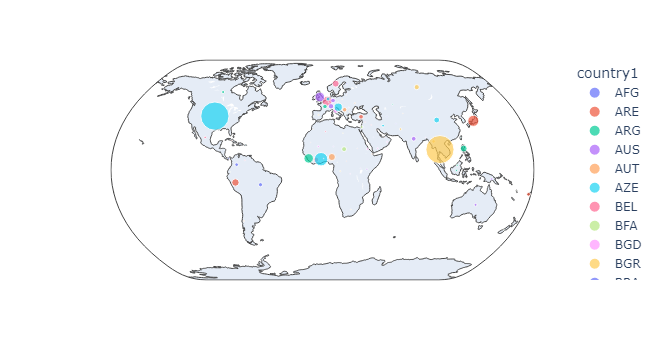

In [55]:
import plotly.express as px
fig = px.scatter_geo(paises, locations='country1',
                     color="country1", # which column to use to set the color of markers
                     hover_name="country1", # column added to hover information
                     size="disasters", # size of markers
                     projection="natural earth")
fig.show()

### Image of the mop to the PDF view

<img src="map.png"> 

# Week 9 Project Submission: Project Report Update

In [57]:
df.head(2)

id keyword location                                               text  \
0   1     NaN      nan  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      nan             Forest fire near La Ronge Sask. Canada   

   target                                         text_clean  word_count  \
0       1  our deeds are the reason of this earthquake ma...          13   
1       1              forest fire near la ronge sask canada           7   

   size                                         tokenizado  \
0    68  [our, deeds, are, the, reason, of, this, earth...   
1    37      [forest, fire, near, la, ronge, sask, canada]   

                       text_clean_non_stopwords  word_count_non_stopwords  \
0  deeds reason earthquake may allah forgive us                         7   
1         forest fire near la ronge sask canada                         7   

   size_non_stopwords country country1  
0                  44     nan      USA  
1                  37     nan      THA

In [58]:
token_lists = [word_tokenize(each) for each in df.text_clean]
tokens = [item for sublist in token_lists for item in sublist]

In [59]:
print("Number of unique tokens then: ", len(set(tokens)))

Number of unique tokens then:  21835


In [61]:
import nltk
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
# noise_words


179


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oscar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
one_percentile

218

In [64]:
top_1_percentile[:10]

[('the', 3263),
 ('a', 2188),
 ('in', 1977),
 ('to', 1945),
 ('of', 1823),
 ('and', 1418),
 ('i', 1398),
 ('is', 944),
 ('for', 890),
 ('on', 853)]

In [65]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('scabs', 1),
 ('dauntedpsyche', 1),
 ('gently', 1),
 ('dabbed', 1),
 ('rag', 1),
 ('crawling', 1),
 ('hea', 1),
 ('rams', 1),
 ('soldi', 1),
 ('httptcoobszybaj', 1)]

In [66]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [67]:
len(noise_words)

615

## Building our machine learning model

In [126]:
df_model = df[['text_clean', 'target']]
df_model.head(2)

text_clean  target
0  our deeds are the reason of this earthquake ma...       1
1              forest fire near la ronge sask canada       1

In [127]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [147]:
# Creating a python object of the class CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

In [148]:
reviews_train, reviews_test = train_test_split(df_model, test_size=0.2, random_state=0)

In [149]:
X_train_bow = bow_counts.fit_transform(reviews_train.text_clean)
X_test_bow = bow_counts.transform(reviews_test.text_clean)

C:\Users\oscar\Documents\Git\ds4a\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'sha', 'wo'] not in stop_words.



In [150]:
y_train_bow = reviews_train['target']
y_test_bow = reviews_test['target']

In [151]:
X_train_bow.shape[0]

6090

In [152]:
len(y_train_bow)

6090

In [153]:
y_test_bow.value_counts() / y_test_bow.shape[0]

0    0.581747
1    0.418253
Name: target, dtype: float64

### Applying logistic regression

In [162]:
lr_model_all = LogisticRegression(C=0.9, solver="liblinear") #c = float
lr_model_all.fit(X_train_bow, y_train_bow)

LogisticRegression(C=0.9, solver='liblinear')

In [163]:
len(y_test_bow)

1523

In [165]:
# Predicting the output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.7109170305676855
Accuracy:  78.26657912015759


In [166]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [167]:
predictions = pd.DataFrame()
predictions['Text'] = reviews_test['text_clean']
predictions['Target'] = reviews_test['target']
predictions['Predicted_dissaster'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [168]:
predictions.head(10)

Text  Target  \
311   katiekatcubs you already know how this shit go...       0   
4970  lemairelee danharmon people near meltdown comi...       0   
527    tix calgary flames vs col avalanche preseason...       0   
6362  if you ever think you running out of choices i...       0   
800   if you dotish to blight your car go right ahea...       0   
3074                               electrocute yourself       0   
1833  thief broke front window of hicksville store s...       0   
2272  doone silver architects has won permission to ...       0   
1234  fire destroys two buildings on nd street in ma...       1   
1326  minsuwoongs i completely understand because i ...       0   

      Predicted_dissaster  Predicted_probability  
311                     0               0.123315  
4970                    0               0.221547  
527                     0               0.374998  
6362                    0               0.067692  
800                     0               0.113606  
3074                    0               0.129629  
1833                    0               0.216512  
2272                    0               0.227224  
1234                    1               0.940109  
1326                    0               0.311816

In [169]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

C:\Users\oscar\Documents\Git\ds4a\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



words   weights
4272              etoffe  1.201145
5423             grilled  0.705798
16807       trafficalert  0.656414
14135           released  0.640740
15834                stm  0.590618
14399         rjailbreak  0.553189
16740           tornados  0.542514
12527                nrc  0.517447
6458      httptcoavubkrv  0.501243
8280    httptcoorovzfsku  0.434428
8382   httptcopmhmmkspaq  0.369301
14724               sara  0.352773
4671               films  0.350408
4672              filter  0.350408
13518         preemptive  0.345914

In [170]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

words   weights
14374           ripping -0.264413
12734           onåêthe -0.271512
3786            driving -0.281452
5549               hail -0.301217
3035              cyber -0.303109
14843              scum -0.309331
12738              oomf -0.312463
13332          playoffs -0.314468
12368           niagara -0.354173
17821             winik -0.364098
14237          reserved -0.383282
12729            ontejc -0.400756
14320           rfcgeom -0.432510
5845          hijacking -0.439478
6904   httptcoejghnafhy -0.507640

# Otros parametros, sin palabras ruido

In [171]:
# Changes with respect to the previous code
# 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram,3-gram and 4-gram)
# 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_bow = bow_counts.fit_transform(reviews_train.text_clean)
X_test_bow = bow_counts.transform(reviews_test.text_clean)

In [172]:
lr_model_all_new = LogisticRegression(C=0.9, solver="liblinear")
lr_model_all_new

LogisticRegression(C=0.9, solver='liblinear')

In [173]:
# Training the model
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.7402135231316725
Accuracy:  80.82731451083389


### Palabras asociadas a comentarios de desastres o no desastres

In [177]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:5]

C:\Users\oscar\Documents\Git\ds4a\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



words   weights
71991   hiroshima  1.666854
56060       fires  1.516710
29185  california  1.347109
48157  earthquake  1.264320
57166      floods  1.201856

In [176]:
lr_weights.sort_values(['weights'],ascending = False)[-5:]

words   weights
83767        im -0.748910
114173      new -0.769970
142987  screams -0.810002
24180      body -0.850172
191837      you -1.088377

### Fandom forests classification

In [180]:
rf_model_all = RandomForestClassifier(n_estimators=200)

# Training the data
rf_model_all.fit(X_train_bow, y_train_bow)

# Generating predictions
test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)


In [181]:
print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.6551373346897253
Accuracy:  77.74130006565989


## TF-IDF model

In [184]:
# Create a vectorizer - we still feed in our stop words, although
# these are less relevant now as TF-IDF would weight them less 
# anyway.
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1,3)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.text_clean)
X_test_tfidf = tfidf_counts.transform(reviews_test.text_clean)

C:\Users\oscar\Documents\Git\ds4a\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'sha', 'wo'] not in stop_words.



In [185]:
# Create the classifier
lr_model_tf_idf = LogisticRegression(solver="liblinear")

# Train the classifier
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predict the results
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.6754468485418628
Accuracy:  77.34734077478662


### Increasing the model accuracy

In [186]:
# Changes: Removing stop words and including 1-4 grams in the tf-idf data

tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.text_clean)
X_test_tfidf = tfidf_counts.transform(reviews_test.text_clean)

In [187]:
# Setting up the model class
lr_model_tf_idf_new = LogisticRegression(solver="liblinear", penalty='l1', C=10)

# Training the model 
lr_model_tf_idf_new.fit(X_train_tfidf, y_train_bow)

# Prediciting the results
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

In [190]:
## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.7419112114371708
Accuracy:  77.47866053841102


In [188]:
lr_weights = pd.DataFrame(
    list(
        zip(tfidf_counts.get_feature_names(), lr_model_tf_idf_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

C:\Users\oscar\Documents\Git\ds4a\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



words    weights
71991    hiroshima  37.447898
42624   derailment  36.618073
56060        fires  30.126086
186717    wildfire  29.059893
51044    evacuated  27.113582
107373          mh  26.077945
175823     typhoon  25.767466
96112       killed  25.686142
57166       floods  25.580742
173441       train  24.957829

In [189]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

words    weights
29008       cake -14.015396
87173      in to -14.181601
147937   slicker -14.265625
145498      shes -14.425624
22075     better -15.882059
131198      poll -16.889290
84791      in an -17.263272
191837       you -17.562730
48381       ebay -19.009964
132172  pregnant -24.493017

## Word embeddings model

In [191]:
from IPython.display import Image
from IPython.core.display import HTML

In [195]:
import gensim
import os

In [196]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(os.getcwd(), 'glove.twitter.27B.200d_out.txt'),
    binary=False,
    unicode_errors='ignore'
)

In [209]:
print("The embedding for great is", len(model['great']), "dimensional")

model['cristian']

The embedding for great is 200 dimensional


array([-4.6051e-01, -3.9131e-02,  3.5820e-02, -2.1580e-02,  2.1389e-01,
       -1.2469e-01, -3.6832e-01,  3.7154e-01, -4.4270e-01, -4.2912e-01,
        2.8277e-01, -1.4682e-01, -6.9665e-02,  2.1162e-01,  4.1935e-02,
       -7.5385e-01,  1.1223e-01,  1.5456e-01,  4.6172e-01, -2.6205e-01,
       -4.3679e-01,  3.3515e-01,  6.3308e-01, -8.0130e-01, -1.7447e-02,
       -1.5935e+00, -1.5942e-01,  2.2134e-01, -1.9757e-01, -5.6579e-01,
        5.5851e-01,  6.3869e-01, -1.8653e-01,  1.6158e-01,  3.1223e-01,
       -3.1258e-01,  3.6536e-01, -2.0391e-01,  1.3759e-01,  2.6251e-02,
        1.9745e-03,  2.1172e-01,  6.1721e-01,  2.5626e-01, -6.4366e-01,
        7.9333e-02, -1.1698e-01, -1.6709e-01, -4.6476e-01,  9.8947e-02,
       -1.0924e-01, -3.7198e-01,  5.6373e-01, -3.8480e-01, -1.1440e-01,
        1.1958e-01, -4.8895e-01, -2.1421e-01,  1.6097e-01,  4.1911e-01,
       -2.9062e-01,  2.3235e-01,  1.0391e-01,  4.9268e-01,  8.2443e-01,
        4.2463e-01, -5.1578e-01, -1.4852e-01, -4.3769e-01,  3.92

In [201]:
review_embeddings = []

for each_review in df.text_clean:
    review_average = np.zeros(model.vector_size)
    count_val = 0
    
    for each_word in word_tokenize(each_review):

        # Change to "if True" to remove stop words from the 
        # averaged embeddings
        if False:
            if(each_word.lower() in noise_words):
                print(each_word.lower())
                continue
        
        if(each_word.lower() in model):
            review_average += model[each_word.lower()]
            count_val += 1
    
    review_embeddings.append(list(review_average/count_val))

In [202]:
embedding_data = pd.DataFrame(review_embeddings)
embedding_data = embedding_data.fillna(0)

In [203]:
embedding_data

0         1         2         3         4         5         6    \
0     0.108250  0.188131  0.062986  0.194486 -0.001881 -0.040202  0.564872   
1    -0.220747  0.023442 -0.000856 -0.125343 -0.073099  0.136962 -0.162845   
2    -0.006144  0.052788 -0.110666  0.068702  0.006853 -0.089639  0.340205   
3    -0.047149  0.234074 -0.174452 -0.046020 -0.005730 -0.268226  0.343314   
4     0.044636  0.103785 -0.093103 -0.084075 -0.118164 -0.009113  0.315092   
...        ...       ...       ...       ...       ...       ...       ...   
7608 -0.013925 -0.231666  0.185319 -0.050083 -0.197415 -0.005173  0.221646   
7609  0.111583  0.124117  0.136007  0.052229  0.014320  0.201048  0.014427   
7610  0.095854 -0.211395  0.198540 -0.174637 -0.198384  0.274523 -0.261606   
7611  0.013837 -0.060608 -0.163748  0.156594 -0.039200  0.087506 -0.052470   
7612 -0.101475  0.111370 -0.285655 -0.092477 -0.262105 -0.200418 -0.102116   

           7         8         9    ...       190       191       192  \
0    -0.007825 -0.116076  0.029780  ... -0.105513  0.069882  0.143943   
1    -0.100948 -0.053673 -0.254210  ...  0.244066 -0.045801  0.292360   
2     0.061716 -0.007709 -0.083422  ...  0.114905  0.007426 -0.059770   
3    -0.257501  0.096533 -0.254752  ...  0.388073 -0.063323  0.002195   
4    -0.068271 -0.200368 -0.280023  ...  0.076920  0.056044  0.170939   
...        ...       ...       ...  ...       ...       ...       ...   
7608 -0.181914 -0.016537 -0.134433  ...  0.269424 -0.057431 -0.013332   
7609 -0.199076 -0.086736 -0.166366  ...  0.118171 -0.100123 -0.042156   
7610 -0.162661  0.131034 -0.275409  ...  0.214036 -0.065755  0.091812   
7611 -0.131980  0.083258 -0.244543  ... -0.085794 -0.082659 -0.013178   
7612 -0.059997  0.161464 -0.308507  ...  0.303643 -0.055302  0.031210   

           193       194       195       196       197       198       199  
0    -0.060606 -0.081343 -0.115012  0.183697  0.164704  0.130413 -0.150103  
1    -0.093404  0.218210  0.085573  0.242977 -0.209306  0.169360 -0.036763  
2    -0.081865  0.004269 -0.066185  0.180537  0.083985  0.074647  0.030364  
3    -0.127794  0.134719 -0.020544  0.116155  0.026271 -0.008799  0.203327  
4     0.050509  0.147566 -0.006420  0.190596 -0.061581 -0.088374 -0.045519  
...        ...       ...       ...       ...       ...       ...       ...  
7608 -0.050611  0.169764 -0.150342  0.064910 -0.019655 -0.005054 -0.005577  
7609  0.020276 -0.001781  0.013951  0.132407 -0.008701 -0.175350 -0.196120  
7610  0.253508  0.060232 -0.108594  0.332066 -0.240490  0.156695  0.223105  
7611 -0.032189 -0.011975 -0.206954 -0.003910  0.161374  0.136489 -0.083430  
7612 -0.037192  0.108386 -0.075800  0.063701 -0.096478 -0.174138 -0.014613  

[7613 rows x 200 columns]

In [204]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed =  train_test_split(
    embedding_data,
    df.target,
    test_size=0.2,
    random_state=0
)

In [205]:
lr_model = LogisticRegression(penalty="l1", C=10, solver="liblinear")
lr_model.fit(X_train_embed, y_train_embed)
test_pred_lr_prob = lr_model.predict_proba(X_test_embed)
test_pred_lr_all = lr_model.predict(X_test_embed)

print("F1 score: ", f1_score(y_test_embed, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_embed, test_pred_lr_all)*100)

F1 score:  0.7502102607232969
Accuracy:  80.49901510177281


## Summary
- First of all, we imported all the libraries that would be useful to analyze the information of the datasets (pandas, numpy, matplotlib, etc)

- Then, we uploaded the two datasets (train and test datasets) into our notebook and we gave a basic description of it, describing its columns and summarizing some important information for our case, like the most repetitive target in the data (0: not disaster)

- Thirdly, we cleaned the data, in order to extract the most valuable information from it. We removed rows, which do not have 1 and 0 values in target column, punctuations, numbers, uppercase, hyperlinks and square brackets.

- For the feature engineering section, we added some useful columns such as: number of words in the tweets and text length (total characters). We found out that this dataset was probably made before 2017, when the tweet limit was 140 characters. Regarding location, we saw that it is important to standarize some words that are different but refer to the same country (USA and United States for example).

- Finally, we analyze the data, using some useful visualizations such as: histograms, barplots and word clouds graphs, focusing on the most repetitive words. Here we found an important opportunity with “stop words” that are popular in most of the tweets, but without a context do not give us a lot of information.


### Repository
https://github.com/oscarciceri/Disaster_Monitoring_Based_On_Tweets/blob/main/EDA_extended.ipynb